# 1. Packages

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 2. Data

## Read Raw Data

In [2]:
df = pd.read_csv('../data/training_final_latcorr.csv')

In [3]:
df.columns

Index(['field_1', 'Name', 'Longitude', 'Latitude', 'CO2 (mg C m¯² d¯¹)',
       'CH4 (mg C m-2 d-1)', 'CO2 (g/kWh)', 'CH4 (g/kWh)',
       'Area / Electricity', 'Area_km2', 'Age', 'Volume_km3',
       'Areakm2_div_Volkm3', 'org_c', 'temp_annual_avg',
       'temp_diff_summer_winter_lc', 'temp_spring_avg_lc', 'temp_spring_avg',
       'temp_summer_avg_lc', 'temp_summer_avg', 'temp_fall_avg_lc',
       'temp_fall_avg', 'temp_winter_avg_lc', 'temp_winter_avg',
       'NDVI_annual_avg', 'NDVI_spring_avg_lc', 'NDVI_spring_avg',
       'NDVI_summer_avg_lc', 'NDVI_summer_avg', 'NDVI_fall_avg_lc',
       'NDVI_fall_avg', 'NDVI_winter_avg_lc', 'NDVI_winter_avg',
       'npp_annual_avg', 'npp_spring_avg_lc', 'npp_spring_avg',
       'npp_summer_avg_lc', 'npp_summer_avg', 'npp_fall_avg_lc',
       'npp_fall_avg', 'npp_winter_avg_lc', 'npp_winter_avg', 'erosion',
       'precip'],
      dtype='object')

## Cleaning data

In [4]:
included_columns = ['CH4 (mg C m-2 d-1)', 'Age', 'org_c', 'temp_annual_avg', 'temp_diff_summer_winter_lc', 'NDVI_annual_avg', 'npp_annual_avg', 'erosion', 'precip']

clean_df = df[included_columns].copy()

print("df.shape =", df.shape)
print("clean_df.shape =", clean_df.shape)

df.shape = (154, 44)
clean_df.shape = (154, 9)


## Clean Column Names

In [5]:
col_rename_dict = {
    'CH4 (mg C m-2 d-1)': 'ch4_emissions',
    'Area / Electricity': 'area_by_electricity',
    'Area_km2':           'area',
    'Volume_km3':         'volume',
    'Areakm2_div_Volkm3': 'area_by_volume',
    'temp_diff_summer_winter_lc': 'temp_diff_summer_winter_ic'
}
clean_df.rename(columns = col_rename_dict, inplace = True)

col_rename_dict = dict(zip(
    clean_df.columns, 
    [col.lower() for col in clean_df.columns]
))
clean_df.rename(columns = col_rename_dict, inplace = True)

clean_df.columns

Index(['ch4_emissions', 'age', 'org_c', 'temp_annual_avg',
       'temp_diff_summer_winter_ic', 'ndvi_annual_avg', 'npp_annual_avg',
       'erosion', 'precip'],
      dtype='object')

## Create New Columns/Features

In [6]:
clean_df.columns

Index(['ch4_emissions', 'age', 'org_c', 'temp_annual_avg',
       'temp_diff_summer_winter_ic', 'ndvi_annual_avg', 'npp_annual_avg',
       'erosion', 'precip'],
      dtype='object')

In [7]:
clean_df['log_ch4_emissions'] = np.log(clean_df['ch4_emissions'])

## Create Reduced Data

In [8]:
reduced_df = clean_df.dropna()
reduced_df.shape

(95, 10)

# Models

In [9]:
reduced_df.shape

(95, 10)

In [10]:
reduced_df.columns

Index(['ch4_emissions', 'age', 'org_c', 'temp_annual_avg',
       'temp_diff_summer_winter_ic', 'ndvi_annual_avg', 'npp_annual_avg',
       'erosion', 'precip', 'log_ch4_emissions'],
      dtype='object')

## Create Train / Test datasets

In [9]:
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import GridSearchCV, LeaveOneOut, LeavePOut, RepeatedKFold, train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler, StandardScaler # robust_scale
from sklearn.svm import SVR

In [10]:
target = 'log_ch4_emissions'

features = ['age', 'org_c', 'temp_annual_avg', 'temp_diff_summer_winter_ic', 'ndvi_annual_avg', 'npp_annual_avg', 'erosion', 'precip']

X = reduced_df[features]
y = reduced_df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

print("X_train.shape =", X_train.shape)
print("X_test.shape  =", X_test.shape)
print("y_train.shape =", y_train.shape)
print("y_test.shape  =", y_test.shape)

X_train.shape = (71, 8)
X_test.shape  = (24, 8)
y_train.shape = (71,)
y_test.shape  = (24,)


## KNN

In [13]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('knr', KNeighborsRegressor())
])

pipeline.fit(X_train, y_train)


print("Train score =", pipeline.score(X_train, y_train))
print("Test score  =", pipeline.score(X_test, y_test))

Train score = 0.6610158759069833
Test score  = 0.5939219215382908


In [14]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('knr', KNeighborsRegressor())
])

parameters = {
    'knr__n_neighbors': range(1, round(len(y_train) / 2)),
    'knr__weights': ['uniform', 'distance']
}

my_cv = RepeatedKFold(n_splits=2, n_repeats=10, random_state=0)

grid_search = GridSearchCV(pipeline, parameters, cv=my_cv, n_jobs=-1, scoring='r2') 

grid_search.fit(X_train, y_train)


print("Best score: %0.3f" % grid_search.best_score_)
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

grid_search.best_estimator_.score(X_test, y_test)


Best score: 0.408
	knr__n_neighbors: 7
	knr__weights: 'distance'


0.5745620297066754

## SVM

In [15]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svr', SVR())
])

pipeline.fit(X_train, y_train)

print("Train score =", pipeline.score(X_train, y_train))
print("Test score  =", pipeline.score(X_test, y_test))

Train score = 0.6137981815161703
Test score  = 0.46397540569896634


In [16]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svr', SVR())
])

parameters = {
    'svr__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'svr__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'svr__gamma': ['scale', 'auto']
    #'svr__gamma': [0.0001, 0.001, 0.01, 0.1],
    #'svr__epsilon': [0.001, 0.01, 0.1]
}

my_cv = RepeatedKFold(n_splits=2, n_repeats=10, random_state=0)

grid_search = GridSearchCV(pipeline, parameters, cv=my_cv, n_jobs=-1, scoring='r2') 

grid_search.fit(X_train, y_train)

print("Best score: %0.3f" % grid_search.best_score_)
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

grid_search.best_estimator_.score(X_test, y_test)

Best score: 0.359
	svr__C: 10
	svr__gamma: 'scale'
	svr__kernel: 'rbf'


0.42087862563231493

## Random Forest

In [11]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('rfr', RandomForestRegressor(random_state=0))
])

pipeline.fit(X_train, y_train)

print("Train score =", pipeline.score(X_train, y_train))
print("Test score  =", pipeline.score(X_test, y_test))

Train score = 0.9115395044143494
Test score  = 0.3727015280073094


In [12]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('rfr', RandomForestRegressor(random_state=0))
])

parameters = {
    'rfr__n_estimators': range(20, 200, 20),
}

my_cv = RepeatedKFold(n_splits=2, n_repeats=10, random_state=0)

grid_search = GridSearchCV(pipeline, parameters, cv=my_cv, n_jobs=-1, scoring='r2') 

grid_search.fit(X_train, y_train)

print("Best score: %0.3f" % grid_search.best_score_)
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

grid_search.best_estimator_.score(X_test, y_test)

Best score: 0.462
	rfr__n_estimators: 140


0.40287172594506737

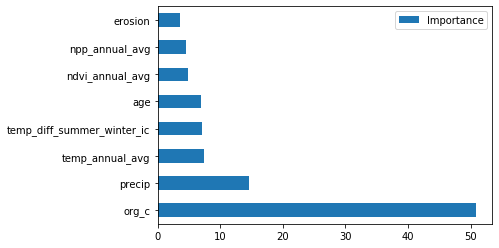

In [18]:
pd.DataFrame(index=X_train.columns,
             data=grid_search.best_estimator_.named_steps['rfr'].feature_importances_*100,
             columns=['Importance']).sort_values(by='Importance', ascending=False).plot(kind='barh')

In [24]:
pd.DataFrame(grid_search.best_estimator_.named_steps['rfr'].feature_importances_*100,
            columns=['ch4_importance'],
            index=X_train.columns).to_csv('../yaniv/ch4_feature_importance.csv')

## Gradient Boosting Regressor

In [19]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('gbr', GradientBoostingRegressor(random_state=0))
])

pipeline.fit(X_train, y_train)

print("Train score =", pipeline.score(X_train, y_train))
print("Test score  =", pipeline.score(X_test, y_test))

Train score = 0.9644713585763195
Test score  = 0.5505972191576489


In [20]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('gbr', GradientBoostingRegressor(random_state=0))
])

parameters = {
    'gbr__n_estimators': range(1, 20, 2),
}

my_cv = RepeatedKFold(n_splits=2, n_repeats=10, random_state=0)

grid_search = GridSearchCV(pipeline, parameters, cv=my_cv, n_jobs=-1, scoring='r2') 

grid_search.fit(X_train, y_train)

print("Best score: %0.3f" % grid_search.best_score_)
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

grid_search.best_estimator_.score(X_test, y_test)

Best score: 0.409
	gbr__n_estimators: 17


0.38392675272975174